# Results

## CUB200 InceptionV3 Features

*Small Reminder:* Baseline should be the same for all setups. Otherwise, something is wrong with the features!

| Part Type | # parts | Global part only<br> <small>*Baseline*</small> | All parts | All parts<br> <small>*Local parts shuffled*</small> | Local parts only | Local parts only<br>  <small>*Local parts shuffled*</small>  |
|-|-|
|  GT Parts | 15 | 87.73 % | **89.45 %** | 89.06¹ % | 85.59 % | 80.60¹ % |
| GT2 Parts | 4  | 87.73 % | **88.94 %** | 88.76¹ % | 84.78 % | 77.77¹ % |
| NAC Parts | 20 | 87.73 % | **88.85 %** | 88.21¹ % | 86.26 % | 83.71¹ % |
| L1P Parts | 4  | 87.73 % | **88.95 %** | 88.83¹ % | 87.38 % | 87.04¹ % |
| L1F Parts | 4  | 87.73 % | 88.66 % | **88.68¹ %** | 86.93 % | 87.02¹ % |


¹ - needs more runs, since randomness involved

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import joblib

from os.path import join
from matplotlib import pyplot as plt
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds import CUB_Annotations, NAB_Annotations, Dataset
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

In [3]:
BASE_DIR = "/home/korsch/Data"

infos = dict(
    
    # VGG19 Features
    
    NAC_single=dict(
        data="NAC/2017-bilinear",
        feat_suffix="10parts_new"
    ),
    
    NAC_vgg=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts"
    ),
    
    
    # ResNet50 Features
    
    NAC_resnet=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.resnet"
    ),
    
    GT_resnet=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.resnet"
    ),
    
    # InceptionV3 Features
    
    L1_pred_inception=dict(
        data="cub200_11_L1_pred",
        feat_suffix="5parts_L1_pred.inception"
    ),
    
    L1_full_inception=dict(
        data="cub200_11_L1_full",
        feat_suffix="5parts_L1_full.inception"
    ),
    
    NAC_inception=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.inception"
    ),
    GT_inception=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.inception"
    ),
    
    GT2_inception=dict(
        data="cub200_11_regrouped",
        feat_suffix="5parts_gt.inception"
    )
)
DATASET="L1_full_inception"
info = infos[DATASET]
DATA_DIR = join(BASE_DIR, "DATASETS", "birds", info["data"])

DUMP = True

# Load data

In [4]:
print("Loading annotations from \"{}\"...".format(DATA_DIR))
annot = CUB_Annotations(DATA_DIR)

print("Creating train and test datasets")
splits = [annot.train_uuids, annot.test_uuids]
features = [join(DATA_DIR, "features", "{}_{}.npz".format(s, info["feat_suffix"])) 
            for s in ["train", "val"]]

train, val = [Dataset(uuids=s, annotations=annot, features=feats) 
               for s, feats in zip(splits, features)]

train_feats = train.features
val_feats = val.features

part_names = list(train._annot.part_name_list)
if "NAC" in DATASET and "single" not in DATASET:
    part_names *= 2
part_names.append("GLOBAL")
assert train_feats is not None
assert val_feats is not None

Loading annotations from "/home/korsch/Data/DATASETS/birds/cub200_11_L1_full"...
Creating train and test datasets


# Some Feature Stats

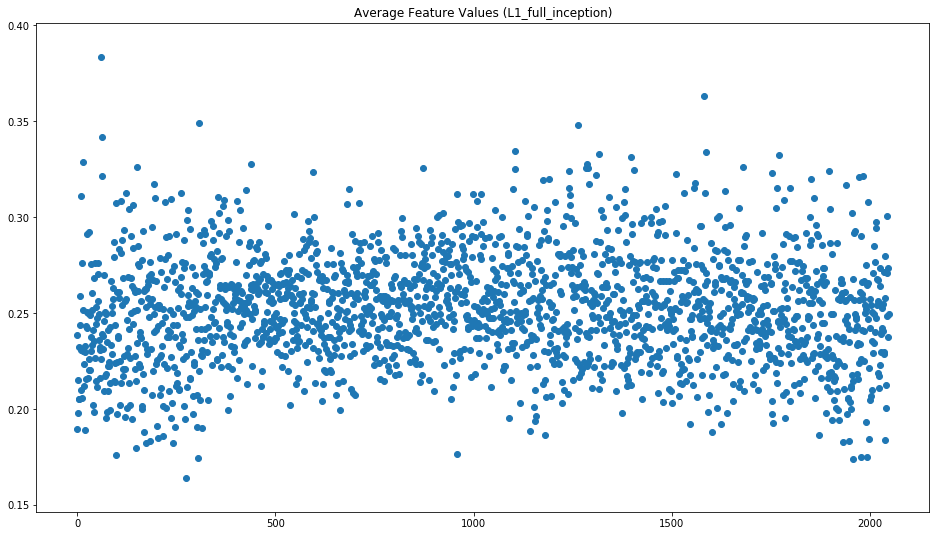

In [5]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(range(train_feats.shape[-1]), train_feats.mean(axis=(0,1)))
ax.set_title("Average Feature Values ({})".format(DATASET))
plt.show()

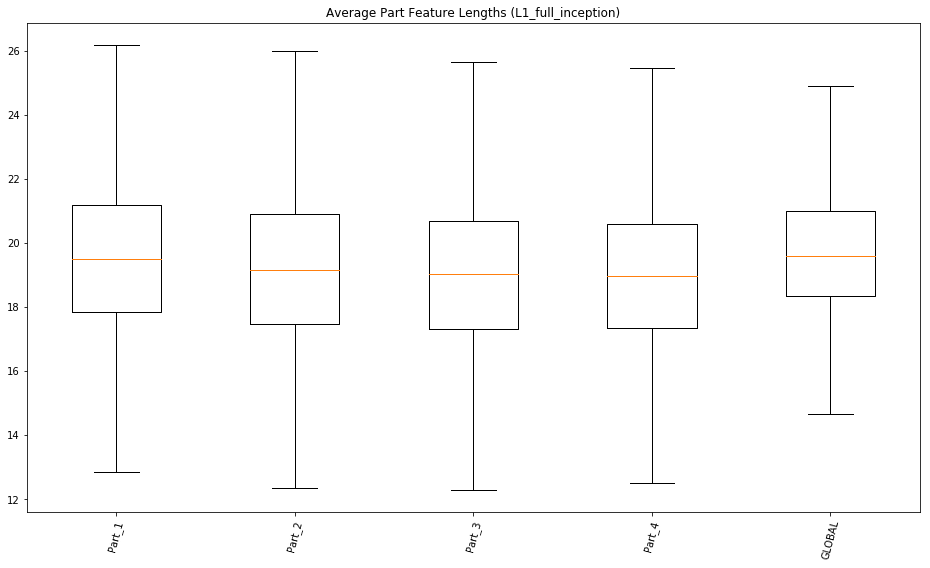

In [6]:
import matplotlib.pyplot as plt

feature_norms = np.sqrt(np.sum(train_feats ** 2, axis=-1))
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Average Part Feature Lengths ({})".format(DATASET))
ax.boxplot(feature_norms, showfliers=False)
ax.set_xticklabels(part_names, rotation=75)
plt.show()

In [7]:
def evaluate(X, y, X_val, y_val, clf_class=LinearSVC, scale=False):
    print(X.shape, X_val.shape)
    print(y, y_val)
    
    if scale:
        print("Scaling Data...")
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        X_val = scaler.transform(X_val)
    print("Training Classifier...")
    clf = clf_class()
    
    #print(cross_val_score(clf, X, y, cv=3, n_jobs=3))
    
    %time clf.fit(X, y)
    return clf, clf.score(X_val, y_val)

# Train SVM with sparse feature coefficients

# Train SVM on global part only

In [8]:
X, y = train_feats[:, -1, :], train.labels
X_val, y_val = val_feats[:, -1, :], val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_glob_only.npz".format(DATASET))

(5994, 2048) (5794, 2048)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training Classifier...
CPU times: user 28.8 s, sys: 46.9 ms, total: 28.9 s
Wall time: 28.9 s
87.73%


# Train SVM on all parts

In [9]:
X, y = train_feats.reshape(len(train), -1), train.labels
X_val, y_val = val_feats.reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts.npz".format(DATASET))

(5994, 10240) (5794, 10240)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training Classifier...
CPU times: user 2min 7s, sys: 360 ms, total: 2min 7s
Wall time: 2min 7s
88.66%


# Train SVM on local parts only

In [10]:
X, y = train_feats[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts.npz".format(DATASET))

(5994, 8192) (5794, 8192)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training Classifier...
CPU times: user 1min 45s, sys: 256 ms, total: 1min 45s
Wall time: 1min 44s
86.93%


# Shuffle Part Positions

Shuffle parts for each sample. Leave global feature on the correct place.

In [17]:
train_feats_rnd = train_feats.copy()
val_feats_rnd = val_feats.copy()

bar = ProgressBar()

[np.random.shuffle(f[:-1]) for f in bar(train_feats_rnd)]
[np.random.shuffle(f[:-1]) for f in bar(val_feats_rnd)]

print("shuffling ready")

shuffling ready


# Train SVM on all parts

In [18]:
X, y = train_feats_rnd.reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd.reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_all_parts_shuffled.npz".format(DATASET))

(5994, 10240) (5794, 10240)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training Classifier...
CPU times: user 2min 2s, sys: 64.1 ms, total: 2min 2s
Wall time: 2min 2s
88.68%


# Train SVM on local parts only

In [19]:
X, y = train_feats_rnd[:, :-1, :].reshape(len(train), -1), train.labels
X_val, y_val = val_feats_rnd[:, :-1, :].reshape(len(val), -1), val.labels

clf, score = evaluate(X, y, X_val, y_val)
print("{:.2%}".format(score))
if DUMP:
    joblib.dump(clf, "clf_{}_local_parts_shuffled.npz".format(DATASET))

(5994, 8192) (5794, 8192)
[  0   0   0 ... 199 199 199] [  0   0   0 ... 199 199 199]
Training Classifier...
CPU times: user 1min 43s, sys: 24 ms, total: 1min 43s
Wall time: 1min 43s
87.02%
